# Magnetometer Calibration 

Aside from a gyroscope, yaw ($\psi$) can be determined using a magnetometer. We saw gyroscope measurements generated produced an ever increasing difference between the true and estimated values over time. To minimize the drift error, gyroscope measurements can be used in short time intervals and the magnetometer for a long time intervals. 

The yaw angle can be calculated relative to the magnetic pole and then adding the correction value produces yaw relative to the pole. In this exercise, we will calculate yaw relative to the magnetic pole and assume that this is sufficient to execute the flight. After initialization of the magnetometer we do not know the true magnetic north. However, we can measure the magnetic strength along the full circle, in addition to given measurements the orientation of the magnetic pole can be accurately estimated. 

In [9]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import math
from math import sin, cos, tan
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import jdc
import random
from magnetic_field_measurements import measured_field

pylab.rcParams['figure.figsize'] = 10, 10

First we load and plot the measured magnetic field.

* `orientation` contains the $x$ and $y$ projections on the unit vector relative to the assumed zero yaw from which we started measurement. 
* `field_strength` contains the magnetic field strength projections on $x$ and $y$ axis. 

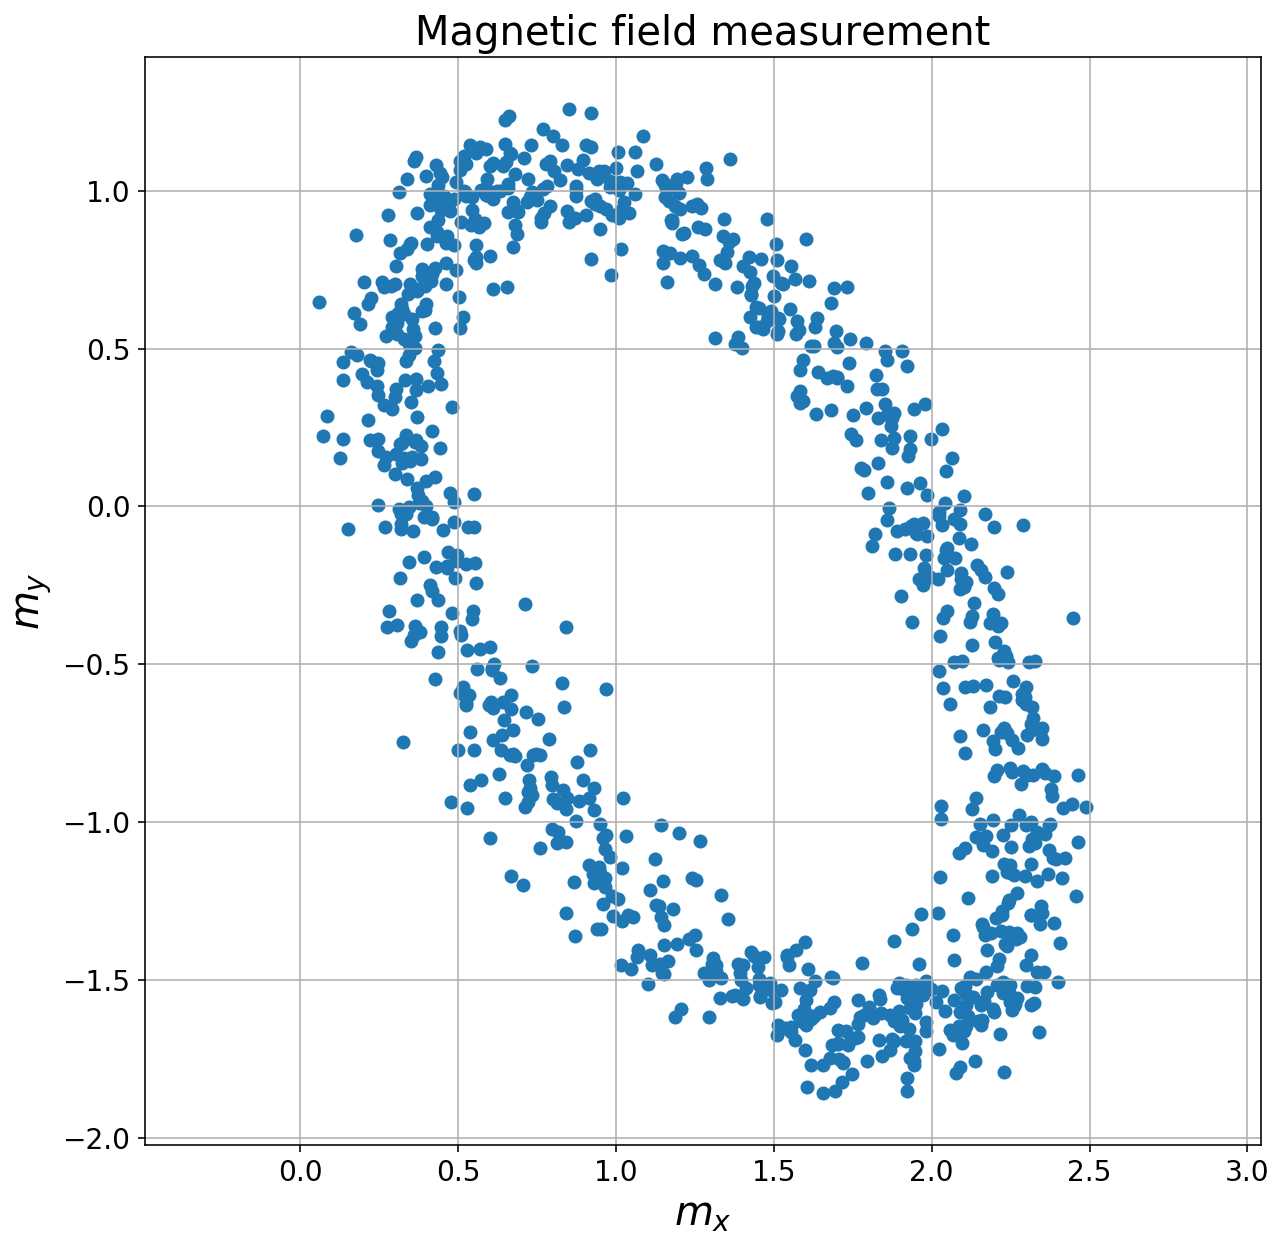

In [10]:
orientation, field_strength = measured_field()

plt.scatter(field_strength[0,:], field_strength[1,:])
plt.axis('equal')
plt.grid()
plt.title('Magnetic field measurement').set_fontsize(20)
plt.xlabel('$m_x$').set_fontsize(20)
plt.ylabel('$m_y$').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

The magnetic field can be models as 

$$
\tilde{m} = b +(I + M) m + \eta
$$

where $m$ is an orientation variable which contains the projections of the unit vector relative to the assumed zero yaw direction relative to which we measured the magnetic strength $\tilde{m}$. 

In the similar fashion as in the previous exercise, we'll use least squares to calculate the $b$ and $(I+M)$ coefficients.

In [11]:
attitude = np.vstack([orientation, np.ones(orientation.shape[1])])
transformation_matrix = np.zeros((2,3))
for i in range(2):
    # TODO: calculate the transformation_matrix containing bias and scailing and cross-correlation elements 
    transformation_matrix[i,:] = np.linalg.lstsq(attitude.T,field_strength[i,:])[0]

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


After obtaining the transform coefficients, we can transform the measured magnetic field into the normalized field strength relative to the already mentioned assumed zero direction. 

$$
(I+M)^{-1}(\tilde{m}-b) +\eta=m 
$$

In [12]:
# TODO: Normalize the measured magnetic field. 
m = np.matmul(np.linalg.inv(transformation_matrix[:, :2]),
              (field_strength - np.reshape(transformation_matrix[:, -1],(2, 1))))


Plotting original measurements with the calibrated ones.

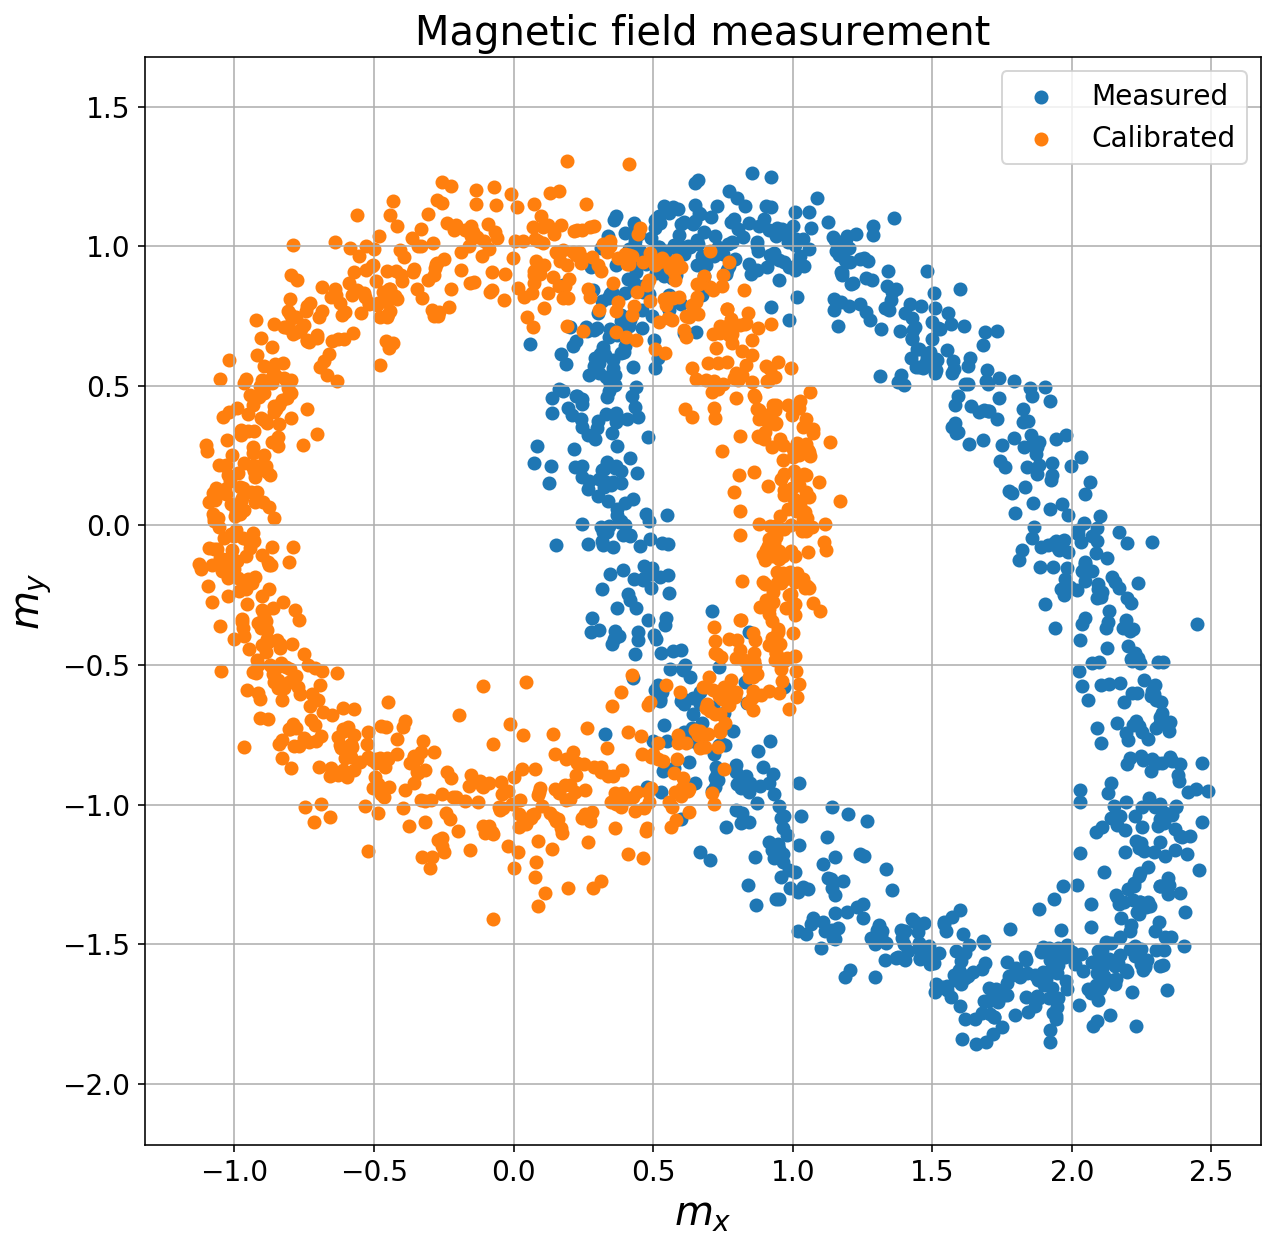

In [13]:
plt.scatter(field_strength[0,:], field_strength[1,:])
plt.scatter(m[0,:], m[1,:])
plt.legend(['Measured','Calibrated'],fontsize = 14)
plt.axis('equal')
plt.grid()
plt.title('Magnetic field measurement').set_fontsize(20)
plt.xlabel('$m_x$').set_fontsize(20)
plt.ylabel('$m_y$').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()


Ellips in two-dimensional space can be represented as:

$$
\begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} b_x\\ b_y \end{bmatrix} + \begin{bmatrix} \cos \Delta \psi &  -\sin  \Delta \psi \\ \sin \Delta \psi & \cos \Delta \psi \end{bmatrix} \begin{bmatrix} s_1 \cos \psi \\ s_2 \sin \psi\end{bmatrix}
$$

where $s_1$ and $s_2$ are the scaling factors and $\Delta \psi$ is the rotation of the major axis. We can employ the given representation and obtain the yaw angle between our assumed zero direction and the actual magnetic pole heading. 

We can then calculate $\Delta \psi$ by dividing proper `transformation_matrix` elements on each other.

In [14]:
delta_psi_1 = np.arctan2(transformation_matrix[1,0],transformation_matrix[0,0])/np.pi*180
print('First estimation of the relative yaw angle is ',delta_psi_1)

delta_psi_2 = np.arctan2(-transformation_matrix[0,1],transformation_matrix[1,1])/np.pi*180
print('Second estimation of the relative yaw angle is ',delta_psi_2)
estimated_delta_psi = (delta_psi_1+delta_psi_2)/2
print('Average relative yaw angle is= ',estimated_delta_psi)

First estimation of the relative yaw angle is  -60.1244214786769
Second estimation of the relative yaw angle is  -59.72124177373616
Average relative yaw angle is=  -59.92283162620653



For a randomly selected magnetic field measurement find the yaw angle relative to the magnetic pole.
First, you will normalize the measurement relative to the assumed zero heading and then add the difference between it and the true magnetic pole heading. 

The yaw for a normalized magnetic field can be calculated as 

$$
\psi = arctan2(-m_y, m_x).
$$

[[ 2.31135349]
 [-0.53783106]]
Yaw relative to the pre-assumed zero  = [-64.93983678]
Yaw relative to the magnetic north =  [-124.86266841]


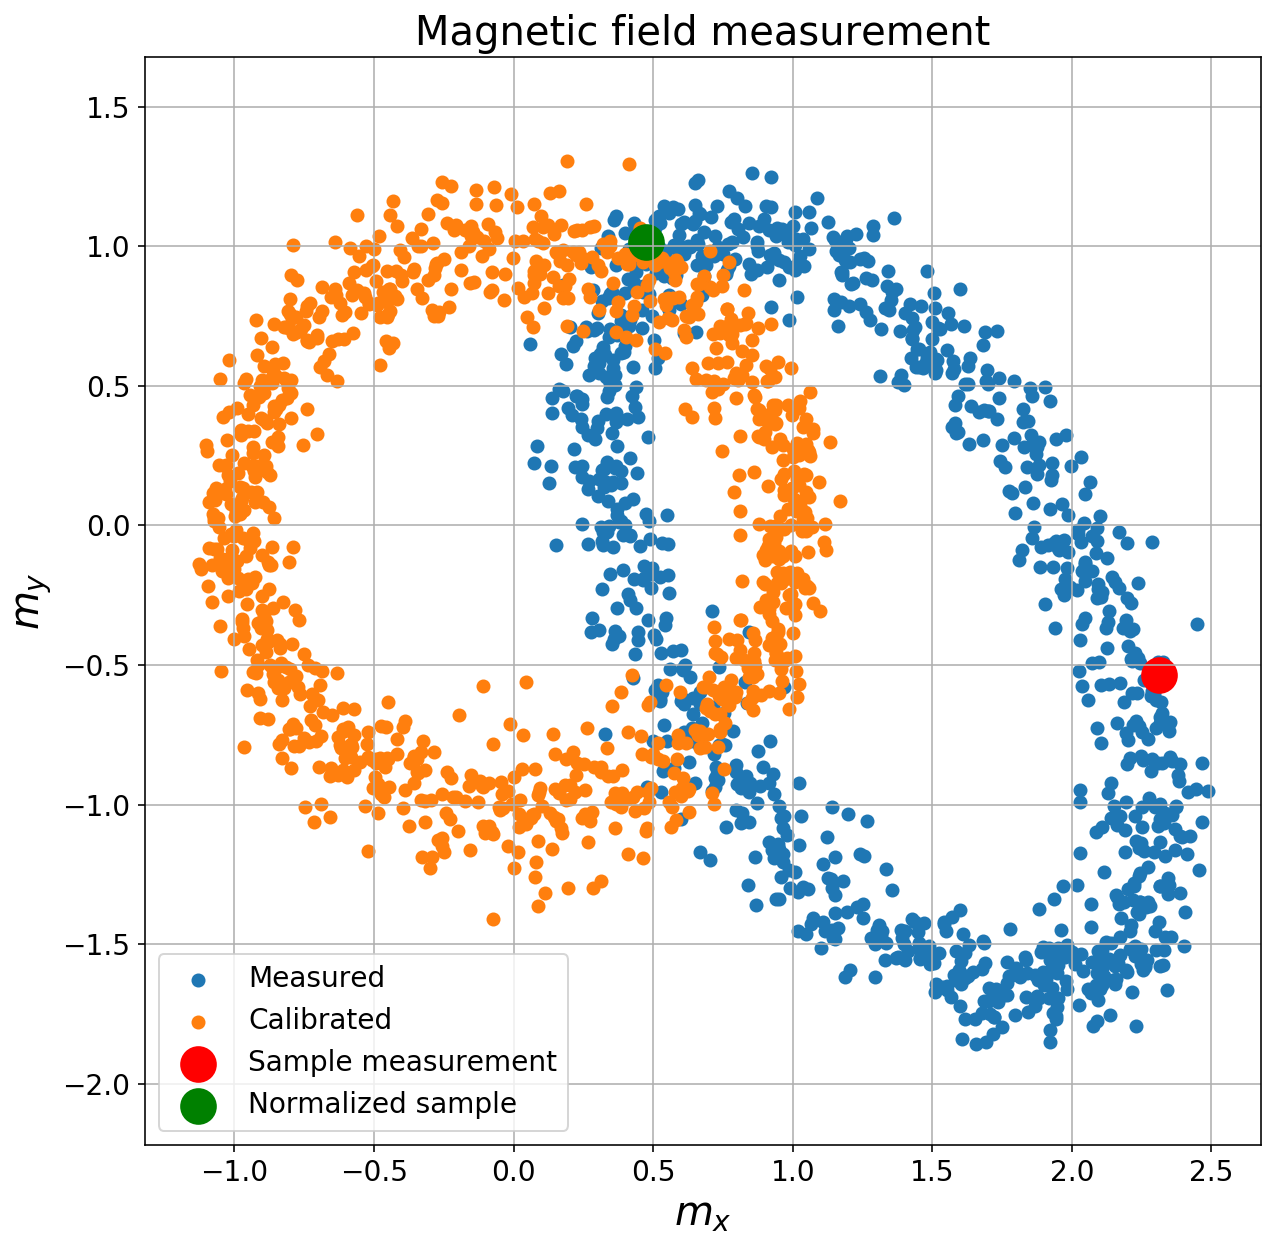

In [20]:
sample_number = 75

#sample_measurement = field_strength[:,sample_number]
sample_measurement = np.array([[2.31135349],[-.53783106]])
print(sample_measurement)


normalized_measurement = np.matmul(np.linalg.inv(transformation_matrix[:, :2]),
             (np.reshape(sample_measurement,(2,1)) - np.reshape(transformation_matrix[:, -1],(2, 1))))


# TODO: Calculate the yaw angle relative to the pre-assumed zero direction and add the correction factor 
yaw_relative_to_introduced_zero = np.arctan2(-normalized_measurement[1],normalized_measurement[0])/np.pi*180
yaw_relative_to_magnetic_north= yaw_relative_to_introduced_zero + estimated_delta_psi

print('Yaw relative to the pre-assumed zero  =',yaw_relative_to_introduced_zero)
print('Yaw relative to the magnetic north = ',yaw_relative_to_magnetic_north)


plt.scatter(field_strength[0,:], field_strength[1,:])
plt.scatter(m[0,:], m[1,:])
plt.scatter(sample_measurement[0], sample_measurement[1],s=300,color='red',marker = 'o')
plt.scatter(normalized_measurement[0], normalized_measurement[1],s=300,color='green',marker = 'o')
plt.legend(['Measured','Calibrated','Sample measurement','Normalized sample'],fontsize = 14)
plt.title('Magnetic field measurement').set_fontsize(20)
plt.xlabel('$m_x$').set_fontsize(20)
plt.ylabel('$m_y$').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.axis('equal')
plt.grid()
plt.show()